**Import Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from typing import List, Tuple
import os


**Load files**

In [4]:
def load_files_from_folder(folder_path: str):
    tsp_files = []
    problems_file = None
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith(".tsp"):
            tsp_files.append(file_path)
        elif filename.endswith(".problems"):
            problems_file = file_path
    if not tsp_files or not problems_file:
        raise ValueError("Folder must contain both .tsp files and a .problems file.")
    return tsp_files, problems_file


**Load Problem Data**

In [5]:
def load_problems_data(problems_file: str):
    problem_data = {}
    with open(problems_file, 'r') as f:
        for line in f:
            if '=' not in line:
                continue
            key, value = line.split('=', 1)
            problem_data[key.strip()] = value.strip()
    return problem_data


**Map Class**

In [6]:
class Map:
    def __init__(self, towns: np.ndarray):
        self.towns = towns

    @staticmethod
    def from_tsp_file(file_path: str):
        towns = []
        with open(file_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.strip() == '' or line.startswith('EOF'):
                    continue
                parts = line.split()
                if len(parts) < 3:
                    continue
                try:
                    town = list(map(float, parts[1:3]))
                    towns.append(town)
                except ValueError:
                    continue
        return Map(np.array(towns))

    def get_towns_count(self):
        return len(self.towns)

    def as_numpy_array(self):
        return self.towns

    def visualize(self, solution=None):
        if solution is None:
            solution = np.arange(len(self.towns))
        plt.figure(figsize=(10, 6))
        plt.plot(self.towns[solution, 0], self.towns[solution, 1], marker='o', color='r')
        plt.plot([self.towns[solution[-1], 0], self.towns[solution[0], 0]],
                 [self.towns[solution[-1], 1], self.towns[solution[0], 1]],
                 marker='o', color='r')
        plt.title("TSP Solution Path")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.grid(True)
        plt.show()


**Covering Salesman Problem Solver Class**

In [7]:
class CoveringSalesmanProblemSolver:
    def __init__(self, map_: Map, generation_size: int = 100, mutate_p: float = 0.05, n_iter: int = 50):
        self.map = map_
        self.generation_size = generation_size
        self.mutate_p = mutate_p
        self.n_iter = n_iter

    def spawn(self):
        m = self.map.get_towns_count()
        n = self.generation_size
        population = [np.random.permutation(np.arange(m)) for _ in range(n)]
        return np.vstack(population)

    def evaluate(self, population: np.ndarray):
        map_ = self.map.as_numpy_array()
        scores = []
        for individual in population:
            distance = sum(
                np.linalg.norm(map_[individual[i]] - map_[individual[i + 1]])
                for i in range(len(individual) - 1)
            )
            distance += np.linalg.norm(map_[individual[-1]] - map_[individual[0]])
            scores.append(distance)
        return np.array(scores)

    def train(self):
        generation = self.spawn()
        scores = self.evaluate(generation)
        bests = []
        for _ in range(self.n_iter):
            bests.append(scores.min())
            generation, scores = self.step(generation, scores)
        bests = np.array(bests)
        solution = generation[scores.argmin()]
        return bests, solution

    def step(self, generation, scores):
        n = self.generation_size
        p = 1 / scores
        p = p / p.sum()
        new_gen = []
        for _ in range(n // 2):
            p1, p2 = self.select(generation, p)
            c1, c2 = self.crossover(p1, p2)
            c1, c2 = self.mutate(c1), self.mutate(c2)
            new_gen.extend([c1, c2])
        new_scores = self.evaluate(np.vstack(new_gen))
        all_scores = np.hstack((scores, new_scores))
        combined = np.vstack((generation, np.vstack(new_gen)))
        indices = np.argsort(all_scores)[:n]
        return combined[indices], all_scores[indices]

    def select(self, population, p):
        indices = np.arange(population.shape[0])
        selected_indices = np.random.choice(indices, 2, p=p)
        return population[selected_indices[0]], population[selected_indices[1]]

    def crossover(self, p1, p2):
        n = len(p1)
        split = np.random.randint(1, n - 1)
        c1 = np.concatenate([p1[:split], p2[~np.isin(p2, p1[:split])]])
        c2 = np.concatenate([p2[:split], p1[~np.isin(p1, p2[:split])]])
        return c1, c2

    def mutate(self, individual):
        if np.random.rand() <= self.mutate_p:
            swap_idx = np.random.choice(len(individual), 2, replace=False)
            individual[swap_idx[0]], individual[swap_idx[1]] = individual[swap_idx[1]], individual[swap_idx[0]]
        return individual


**Define K-Means Clustering**

In [8]:
def apply_kmeans_clustering(towns_array: np.ndarray, n_clusters: int) -> Tuple[np.ndarray, np.ndarray]:

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(towns_array)
    return kmeans.cluster_centers_, labels


**Visualization Clustering**

In [9]:
def visualize_clusters(towns_array: np.ndarray, cluster_centers: np.ndarray, labels: np.ndarray):

    plt.figure(figsize=(10, 6))
    for cluster_idx in np.unique(labels):
        cluster_points = towns_array[labels == cluster_idx]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_idx + 1}")
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='black', marker='x', s=100, label="Cluster Centers")
    plt.title("K-Means Clustering of Towns")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(True)
    plt.show()



**solve CSP with K-means**

In [10]:
def solve_csp_with_kmeans(map_: Map, n_clusters: int, generation_size: int = 100, mutate_p: float = 0.05, n_iter: int = 50):
    towns_array = map_.as_numpy_array()

    # Apply K-Means clustering
    cluster_centers, labels = apply_kmeans_clustering(towns_array, n_clusters)
    visualize_clusters(towns_array, cluster_centers, labels)

    total_distance = 0
    cluster_solutions = []

    for cluster_idx in range(n_clusters):
        print(f"\nSolving CSP for Cluster {cluster_idx + 1}...")

        # Filter towns belonging to this cluster
        cluster_towns = towns_array[labels == cluster_idx]
        sub_map = Map(cluster_towns)

        # Solve CSP for the cluster using Genetic Algorithm
        solver = CoveringSalesmanProblemSolver(sub_map, generation_size, mutate_p, n_iter)
        bests, solution = solver.train()

        # Visualize solution for the cluster
        print(f"Best distance for cluster {cluster_idx + 1}: {bests[-1]}")
        sub_map.visualize(solution)

        # Add to the total distance
        cluster_solutions.append(solution)
        if cluster_idx > 0:
            # Add distance from previous cluster solution
            total_distance += np.linalg.norm(cluster_centers[cluster_idx] - cluster_centers[cluster_idx - 1])

        # Add cluster solution distance
        for i in range(len(solution) - 1):
            total_distance += np.linalg.norm(cluster_towns[solution[i]] - cluster_towns[solution[i + 1]])
        total_distance += np.linalg.norm(cluster_towns[solution[-1]] - cluster_towns[solution[0]])

    print(f"\nTotal distance to cover all clusters: {total_distance}")


Processing Map 1...


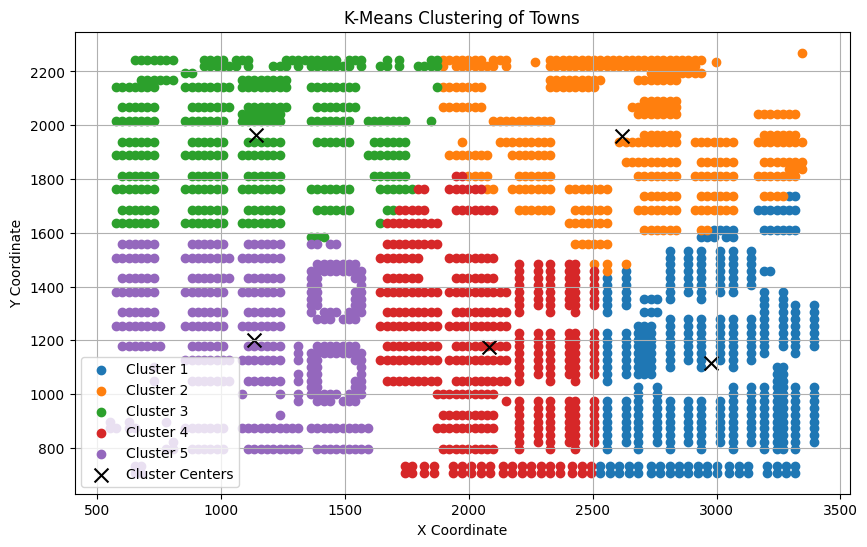


Solving CSP for Cluster 1...
Best distance for cluster 1: 150357.06582511903


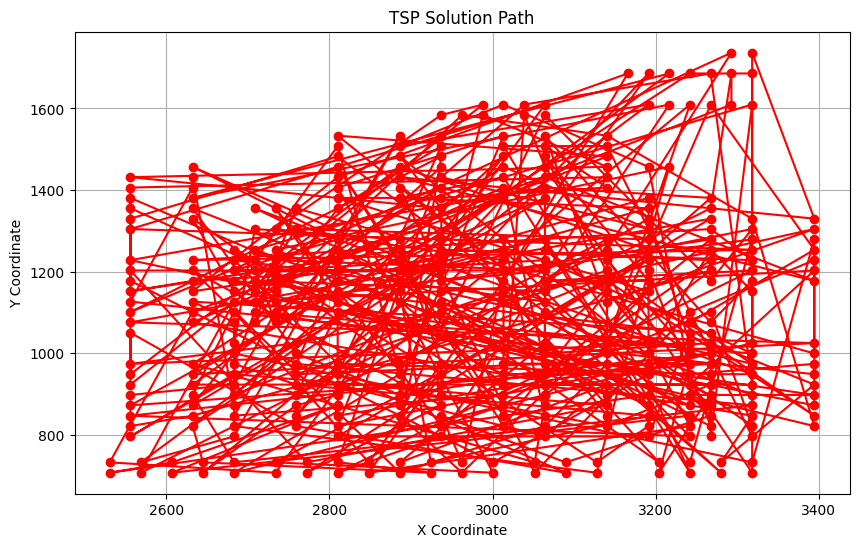


Solving CSP for Cluster 2...
Best distance for cluster 2: 153132.81233128643


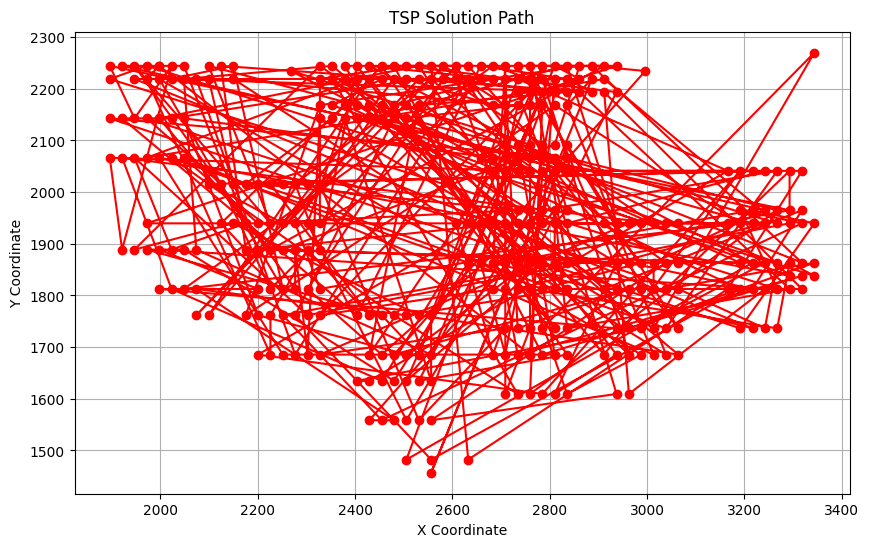


Solving CSP for Cluster 3...
Best distance for cluster 3: 136644.60344062417


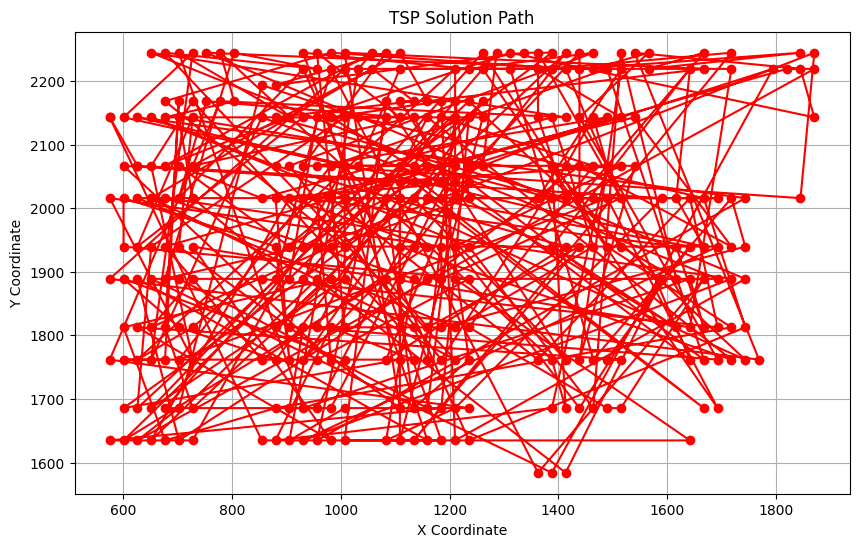


Solving CSP for Cluster 4...
Best distance for cluster 4: 154657.98294189127


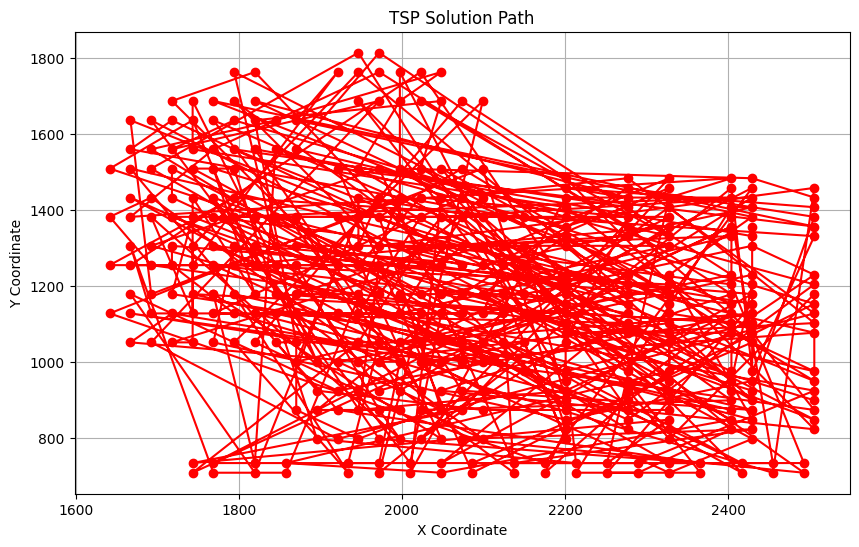


Solving CSP for Cluster 5...
Best distance for cluster 5: 133693.51897596952


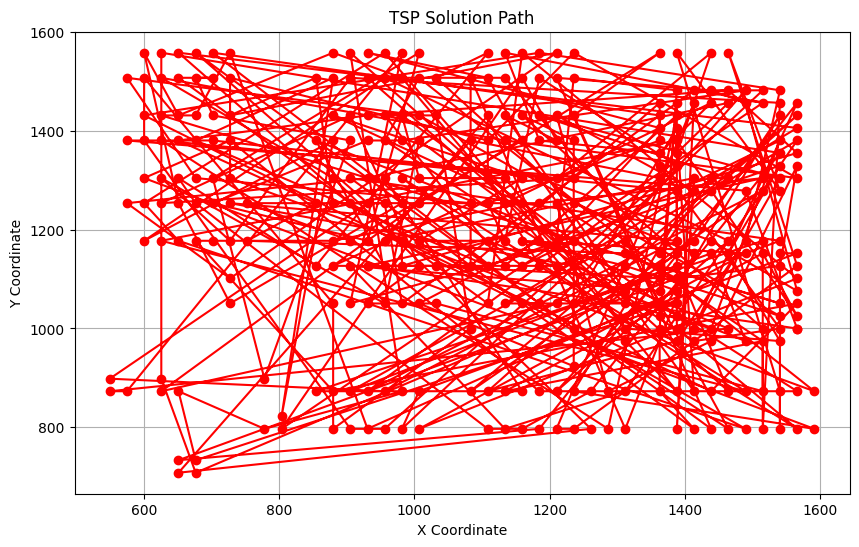


Total distance to cover all clusters: 729721.1174185321
Processing Map 2...


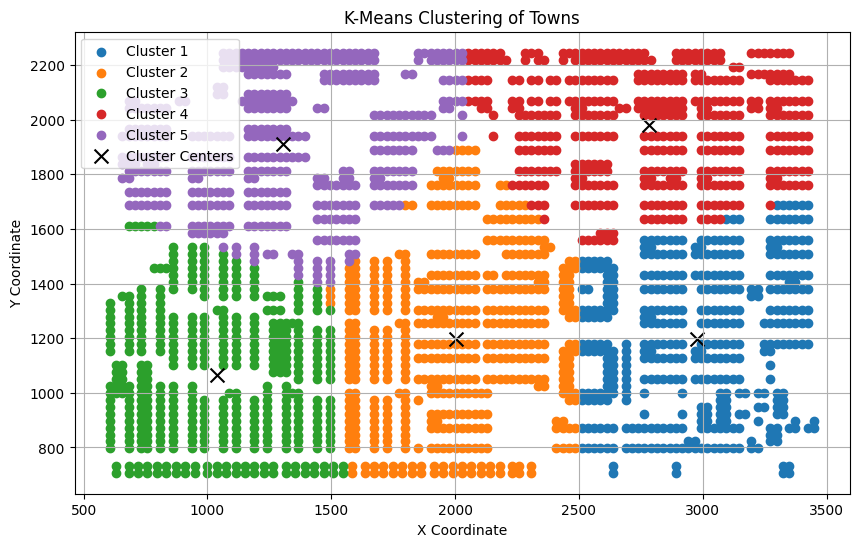


Solving CSP for Cluster 1...
Best distance for cluster 1: 165051.33921313583


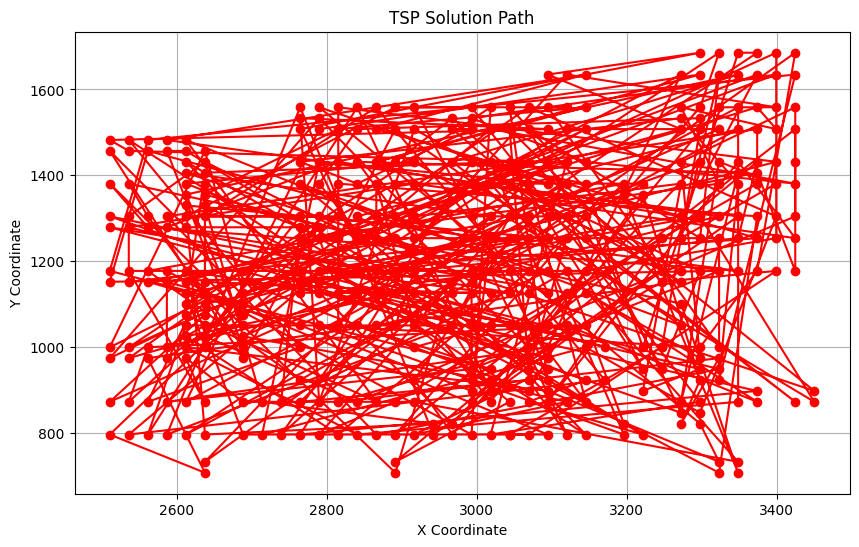


Solving CSP for Cluster 2...
Best distance for cluster 2: 204890.34763106302


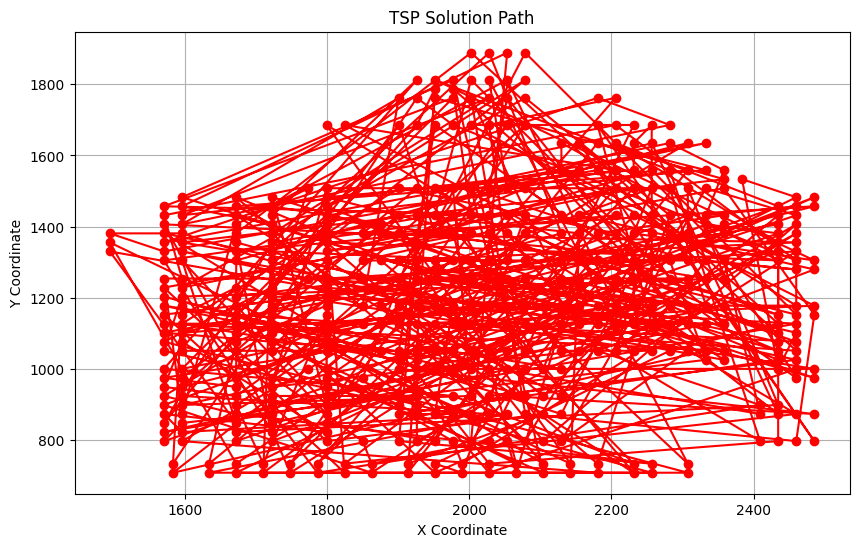


Solving CSP for Cluster 3...
Best distance for cluster 3: 159079.9269931559


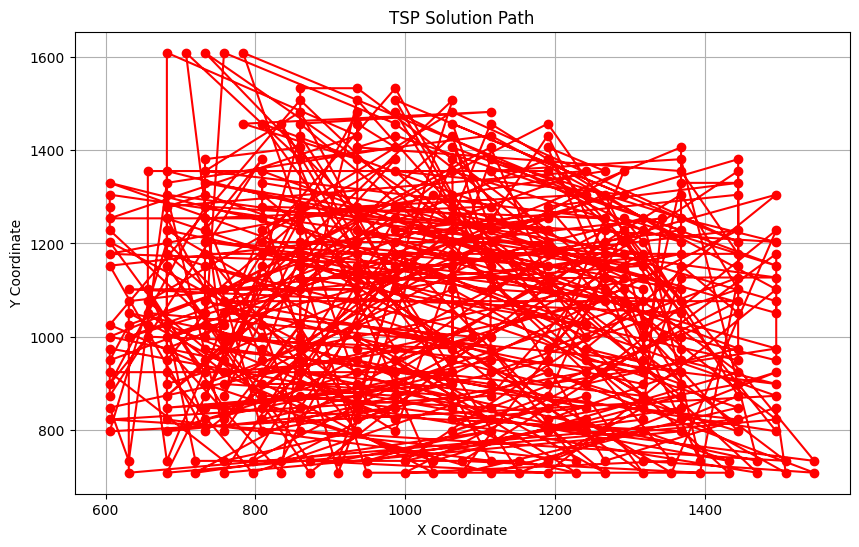


Solving CSP for Cluster 4...
Best distance for cluster 4: 171641.5209970747


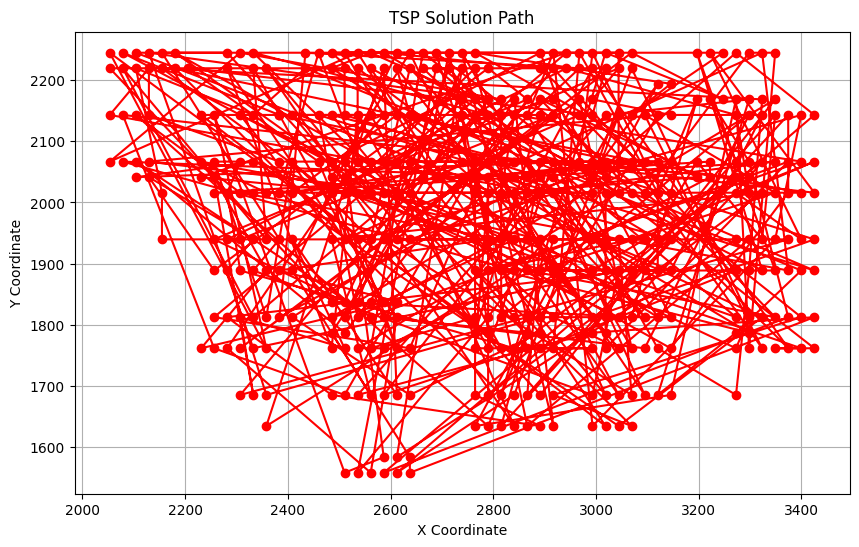


Solving CSP for Cluster 5...
Best distance for cluster 5: 177437.74679492888


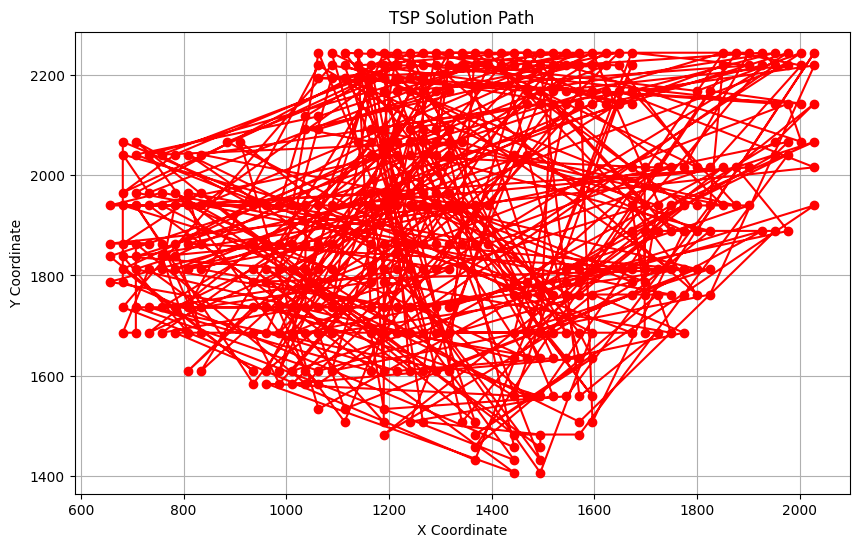


Total distance to cover all clusters: 881178.5047096479


In [11]:
# Define the folder path and load data
folder_path = "tsplib-master"
tsp_files, problems_file = load_files_from_folder(folder_path)

# Solve CSP for each TSP file
for idx, tsp_file in enumerate(tsp_files):
    print(f"Processing Map {idx + 1}...")

    # Create the map
    map_ = Map.from_tsp_file(tsp_file)

    # Number of clusters (this can be adjusted based on problem complexity)
    n_clusters = 5

    # Solve CSP using K-Means clustering
    solve_csp_with_kmeans(map_, n_clusters, generation_size=100, mutate_p=0.05, n_iter=50)
